# Import librairies

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, SimpleRNN, RepeatVector, TimeDistributed, Flatten
from keras import regularizers
from keras.layers import Dropout

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l2

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import chart_studio.plotly as py
import plotly.graph_objects as go  # ou plotly.graph_objs, dependendo da versão
from plotly.offline import init_notebook_mode, iplot

# Basic packages
import datetime # manipulating date formats
import seaborn as sns # for prettier plots


# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


# settings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

# Set seeds to make the experiment more reproducible.
from tensorflow.random import set_seed
from numpy.random import seed
set_seed(1)
seed(1)

# Pré-processamento dos dados

* Carregando os dados
* Padronizando os dados
* Dividindo em treino, teste e validação

In [2]:
data = pd.read_csv('df_rio_interpolado.csv')

In [3]:
data.head(5)

,TEMP
0,27.73
1,27.97
2,25.70
3,26.49
4,22.42


In [4]:
scaler = MinMaxScaler()

In [5]:
# Ajustar o scaler e transformar os dados na coluna TEMP
scaled_data = scaler.fit_transform(data[['TEMP']])

In [6]:
# Salvar o scaler para uso posterior (por exemplo, para reverter a padronização)
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [7]:
# Verificar os dados padronizados
print(data.head())

    TEMP
0  27.73
1  27.97
2  25.70
3  26.49
4  22.42


## Train test split

In [8]:
# Definindo a proporção para treino, validação e teste
train_size = 0.7
valid_size = 0.15
test_size = 0.15

In [9]:
# Total de dados
total_data_len = len(scaled_data)
train_data_len = int(np.floor(total_data_len * train_size))
valid_data_len = int(np.floor(total_data_len * valid_size))
print(total_data_len)
print(train_data_len)
print(valid_data_len)


564
394
84


In [10]:
# Criando conjuntos de treinamento
train_data = scaled_data[0:train_data_len, :]
X_train, Y_train = [], []
for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    Y_train.append(train_data[i, 0])

X_train, Y_train = np.array(X_train), np.array(Y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

print(len(X_train))
print(len(Y_train))
print(len(train_data))

334
334
394


In [11]:
# Criando o conjunto de validação
valid_data = scaled_data[train_data_len:train_data_len + valid_data_len, :]
X_valid, Y_valid = [], []

for i in range(60, len(valid_data)):
    X_valid.append(valid_data[i-60:i, 0])
    Y_valid.append(valid_data[i, 0])

X_valid, y_valid = np.array(X_valid), np.array(Y_valid)
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))
Y_valid = np.array(Y_valid)

print(len(X_valid))
print(len(Y_valid))
print(len(valid_data))

24
24
84


In [12]:
# Ajustando o conjunto de teste para garantir que o tamanho de X_test e Y_test sejam iguais
test_data = scaled_data[train_data_len + valid_data_len - 60:, :]  # Substitua a linha anterior
Y_test = scaled_data[train_data_len + valid_data_len:, :]  # Permanece o mesmo

X_test = []
for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(len(X_test))  # Agora deve corresponder ao tamanho de Y_test
print(len(Y_test))
print(len(test_data))

86
86
146


In [13]:
print(f'X_train length: {len(X_train)}')
print(f'Y_train length: {len(Y_train)}')
print(f'X_valid length: {len(X_valid)}')
print(f'y_valid length: {len(y_valid)}')
print(f'X_test length: {len(X_test)}')
print(f'Y_test length: {len(Y_test)}')

X_train length: 334
Y_train length: 334
X_valid length: 24
y_valid length: 24
X_test length: 86
Y_test length: 86


## Ajuste dos dados para os modelos LSTM e CNN

In [14]:
X_train_series = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.reshape((X_valid.shape[0], X_valid.shape[1], 1))
X_test_series = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)
print('Test set shape', X_test_series.shape)

Train set shape (334, 60, 1)
Validation set shape (24, 60, 1)
Test set shape (86, 60, 1)


In [15]:
# def create_sequences(data, seq_length):
#     sequences = []
#     labels = []
#     for i in range(len(data) - seq_length):
#         sequence = data[i:i+seq_length]
#         label = data[i+seq_length]
#         sequences.append(sequence)
#         labels.append(label)
#     return np.array(sequences), np.array(labels)

# # Defina o comprimento da sequência
# seq_length = 30 
# X_train_series, Y_train_series = create_sequences(scaled_data, seq_length)
# print('Train set shape', X_trains_series.shape)
# print('Validation set shape', X_valid.shape)
# print('Test set shape', X_test.shape)

# Funções de Métricas Utilizadas e Plot dos Resultados

In [16]:
# # Função para calcular MAPE
# def mean_absolute_percentage_error(y_true, y_pred):
#     y_true, y_pred = np.array(y_true), np.array(y_pred)
#     return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [17]:
# # Função para calcular MSE
# def mean_squared_error(y_true, y_pred):
#     return np.mean((y_true - y_pred) ** 2)


In [18]:
# # Função para calcular RMSE
# def root_mean_squared_error(y_true, y_pred):
#     return np.sqrt(mean_squared_error(y_true, y_pred))

In [19]:
# Função para calcular e exibir as métricas de cada modelo
def evaluate_model(model, X_test, Y_test, model_name="Modelo"):
    # Realiza as previsões no conjunto de teste
    Y_pred = model.predict(X_test)
    
    # Calcula as métricas
    mae = mean_absolute_error(Y_test, Y_pred)
    mse = mean_squared_error(Y_test, Y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((Y_test - Y_pred) / Y_test)) * 100
    
    # Exibe os resultados
    print(f"\n{model_name}:")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.4f}%")
    
    return mae, mse, rmse, mape

In [20]:
# Função para exibir os gráficos lado a lado
def plot_multiple_predictions(train_valid_data, y_test, y_pred_models, model_names):
    # Definindo o tamanho da figura e o layout (2 gráficos por linha)
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()  # Achata o array de eixos para indexação direta
    
    for idx, (y_pred, model_name) in enumerate(zip(y_pred_models, model_names)):
        ax = axes[idx]
        
        # Plot dos dados de treino e validação
        ax.plot(range(len(train_valid_data)), train_valid_data, label="Dados de Treinamento e Validação", color="blue")
        
        # Plot dos dados de teste
        ax.plot(range(len(train_valid_data), len(train_valid_data) + len(y_test)), y_test, label="Dados de Teste", color="green")
        
        # Plot das previsões
        ax.plot(range(len(train_valid_data), len(train_valid_data) + len(y_test)), y_pred, label=f"Previsão {model_name}", color="red", linestyle="--")
        
        # Configurações do gráfico
        ax.set_title(f'Ajuste do Modelo com Previsões: {model_name}')
        ax.set_xlabel("Tempo")
        ax.set_ylabel("Valor")
        ax.legend()

    # Ajusta o layout e exibe
    plt.tight_layout()
    plt.show()

# MLP for Time Series Forecasting

* First we will use a Multilayer Perceptron model or MLP model, here our model will have input features equal to the window size.
* The thing with MLP models is that the model don't take the input as sequenced data, so for the model, it is just receiving inputs and don't treat them as sequenced data, that may be a problem since the model won't see the data with the sequence patter that it has.
* Input shape **[samples, timesteps]**.

### Selecao de Hiperparametros

In [21]:
epochs_mlp = 50
batch_mlp = 32
lr = 0.001

### Implementacao e ajuste do Modelo MLP

In [22]:
model_mlp = Sequential()
model_mlp.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
model_mlp.add(Dense(32))
model_mlp.add(Dense(1))
model_mlp.compile(loss='mean_squared_error', optimizer=optimizers.Adam(lr))
# model_mlp.summary()

In [23]:
#history_mlp = model_mlp.fit(X_train, Y_train, 
#                            validation_data=(X_valid, Y_valid), 
#                            epochs=epochs_mlp, 
#                            verbose=2)

history_mlp = model_mlp.fit(X_train, 
                            Y_train, 
                            validation_data=(X_valid, Y_valid), 
                            epochs=epochs_mlp, 
                            batch_size=batch_mlp, 
                            verbose=1)

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0852 - val_loss: 0.0309
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0328 - val_loss: 0.0276
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0256 - val_loss: 0.0251
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0218 - val_loss: 0.0201
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0199 - val_loss: 0.0189
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0183 - val_loss: 0.0185
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0168 - val_loss: 0.0170
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0160 - val_loss: 0.0166
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0153 - val_loss: 0.0162
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0147 - val_loss: 0.0162
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0142 - val_loss: 0.0160
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0138 - val_l

### Implementacao e Ajuste do Modelo MLP com regularização

In [24]:
model_mlp_reg = Sequential()
model_mlp_reg.add(Dense(64, activation='relu', input_dim=X_train.shape[1], 
                     kernel_regularizer=regularizers.l2(0.01)))  # Regularização L2
model_mlp_reg.add(Dense(32, activation='relu', 
                     kernel_regularizer=regularizers.l2(0.01)))  # Regularização L2
model_mlp_reg.add(Dense(1))  # Saída
model_mlp_reg.compile(loss='mean_squared_error', optimizer=optimizers.Adam(lr))
# model_mlp_reg.summary()

In [25]:
#history_mlp_reg = model_mlp_reg.fit(X_train, Y_train, 
#                           validation_data=(X_valid, Y_valid), 
#                            epochs=epochs_mlp, 
#                            verbose=2)

history_mlp_reg = model_mlp_reg.fit(X_train, 
                                    Y_train, 
                                    validation_data=(X_valid, Y_valid), 
                                    epochs=epochs_mlp, 
                                    batch_size=batch_mlp, 
                                    verbose=1)

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 1.0734 - val_loss: 0.9750
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9564 - val_loss: 0.8889
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8687 - val_loss: 0.8061
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7856 - val_loss: 0.7257
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7079 - val_loss: 0.6525
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6370 - val_loss: 0.5861
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5730 - val_loss: 0.5261
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5150 - val_loss: 0.4723
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4627 - val_loss: 0.4238
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4157 - val_loss: 0.3803
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3734 - val_loss: 0.3412
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3356 - val_l

### Implementacao e ajuste do modelo MLP com Dropout

In [26]:
model_mlp_drop = Sequential()
model_mlp_drop.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
model_mlp_drop.add(Dropout(0.3))  
model_mlp_drop.add(Dense(32, activation='relu'))
model_mlp_drop.add(Dropout(0.3))  
model_mlp_drop.add(Dense(1))  
model_mlp_drop.compile(loss='mean_squared_error', optimizer=optimizers.Adam(lr))
# model_mlp_dropout.summary()



In [27]:
#history_mlp_drop = model_mlp_dropout.fit(X_train, Y_train, 
#                            validation_data=(X_valid, Y_valid), 
#                            epochs=epochs_mlp, 
#                            verbose=2)

history_mlp_drop = model_mlp_drop.fit(X_train, 
                                        Y_train, 
                                        validation_data=(X_valid, Y_valid), 
                                        epochs=epochs_mlp, 
                                        batch_size=batch_mlp, 
                                        verbose=1)

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.2099 - val_loss: 0.0327
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0910 - val_loss: 0.0228
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0669 - val_loss: 0.0130
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0474 - val_loss: 0.0194
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0414 - val_loss: 0.0182
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0453 - val_loss: 0.0208
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0363 - val_loss: 0.0172
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0416 - val_loss: 0.0208
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0372 - val_loss: 0.0153
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0322 - val_loss: 0.0135
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0309 - val_loss: 0.0146
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0299 - 

### Implementando e Ajustando modelo MLP com Regularização e Dropout

In [28]:
# Definição do modelo MLP com regularização e dropout
model_mlp_reg_drop = Sequential()
model_mlp_reg_drop.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.001)))
model_mlp_reg_drop.add(Dropout(0.3))  # Taxa de dropout de 20%
model_mlp_reg_drop.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model_mlp_reg_drop.add(Dropout(0.3))
model_mlp_reg_drop.add(Dense(1))  # Camada de saída
model_mlp_reg_drop.compile(optimizer=optimizers.Adam(lr), loss='mse', metrics=['mae'])

In [29]:
history_mlp_reg_drop = model_mlp_reg_drop.fit(X_train, 
                                              Y_train, 
                                              validation_data=(X_valid, Y_valid), 
                                              epochs=epochs_mlp, 
                                              batch_size=batch_mlp, 
                                              verbose=1)


Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.3493 - mae: 0.3405 - val_loss: 0.1952 - val_mae: 0.1640
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2237 - mae: 0.2050 - val_loss: 0.1660 - val_mae: 0.1001
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2067 - mae: 0.1857 - val_loss: 0.1715 - val_mae: 0.1340
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1823 - mae: 0.1535 - val_loss: 0.1603 - val_mae: 0.1229
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1666 - mae: 0.1375 - val_loss: 0.1536 - val_mae: 0.1178
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1629 - mae: 0.1454 - val_loss: 0.1437 - val_mae: 0.1052
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1518 - mae: 0.1277 - val_loss: 0.1390 - val_mae: 0.1064
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1455 - mae: 0.1196 - val_loss: 0.1346 - val_mae: 0.1065
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1401 - mae:

## Comparando os 4 modelos

In [30]:
# Avaliação de cada modelo no conjunto de teste
mae_standard, mse_standard, rmse_standard, mape_standard = evaluate_model(model_mlp, X_test, Y_test, "Modelo Padrão")
mae_reg, mse_reg, rmse_reg, mape_reg = evaluate_model(model_mlp_reg, X_test, Y_test, "Modelo com Regularização")
mae_dropout, mse_dropout, rmse_dropout, mape_dropout = evaluate_model(model_mlp_drop, X_test, Y_test, "Modelo com Dropout")
mae_reg_drop, mse_reg_drop, rmse_reg_drop, mape_reg_drop = evaluate_model(model_mlp_reg_drop, X_test, Y_test, "Modelo com Regularização e Dropout")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

Modelo Padrão:
MAE: 0.0846
MSE: 0.0108
RMSE: 0.1042
MAPE: 23.1160%
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step

Modelo com Regularização:
MAE: 0.0784
MSE: 0.0098
RMSE: 0.0989
MAPE: 17.9582%
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000138A5D553A0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━

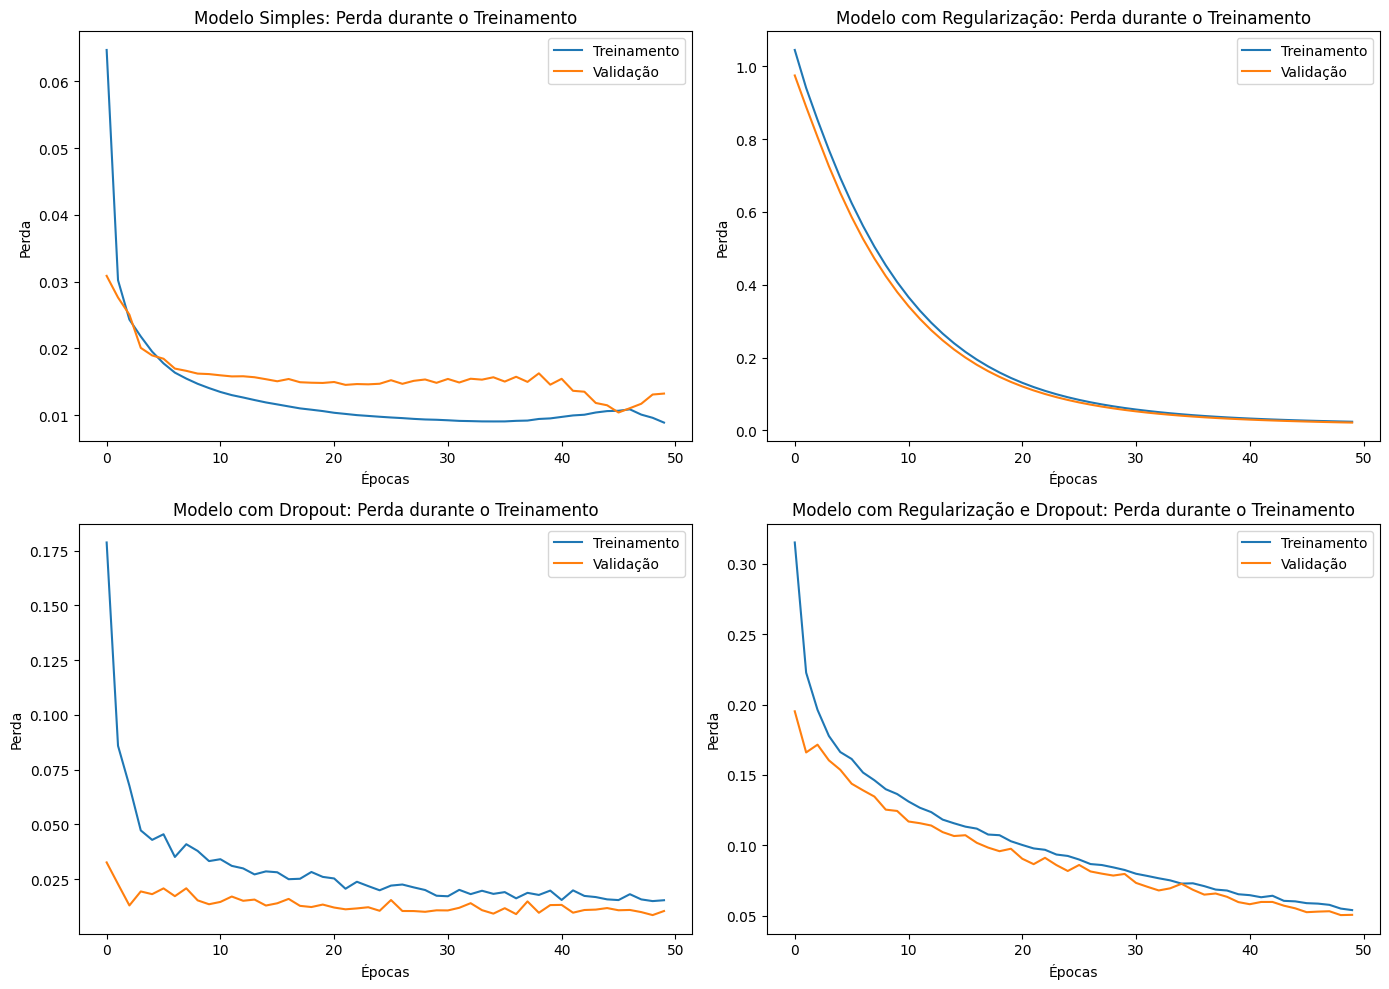

In [31]:
# Gráficos de ajuste combinado no conjunto de treinamento e validação e previsão no conjunto de teste
plt.figure(figsize=(14, 10))

# Modelo Simples
plt.subplot(2, 2, 1)
plt.plot(history_mlp.history['loss'], label='Treinamento')
plt.plot(history_mlp.history['val_loss'], label='Validação')
plt.title('Modelo Simples: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Regularização
plt.subplot(2, 2, 2)
plt.plot(history_mlp_reg.history['loss'], label='Treinamento')
plt.plot(history_mlp_reg.history['val_loss'], label='Validação')
plt.title('Modelo com Regularização: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Dropout
plt.subplot(2, 2, 3)
plt.plot(history_mlp_drop.history['loss'], label='Treinamento')
plt.plot(history_mlp_drop.history['val_loss'], label='Validação')
plt.title('Modelo com Dropout: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Regularização e Dropout
plt.subplot(2, 2, 4)
plt.plot(history_mlp_reg_drop.history['loss'], label='Treinamento')
plt.plot(history_mlp_reg_drop.history['val_loss'], label='Validação')
plt.title('Modelo com Regularização e Dropout: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.tight_layout()
plt.show()

In [32]:
# Gerando previsões para cada modelo
y_pred_mlp = model_mlp.predict(X_test)
y_pred_mlp_reg = model_mlp_reg.predict(X_test)
y_pred_mlp_drop = model_mlp_drop.predict(X_test)
y_pred_mlp_reg_drop = model_mlp_reg_drop.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


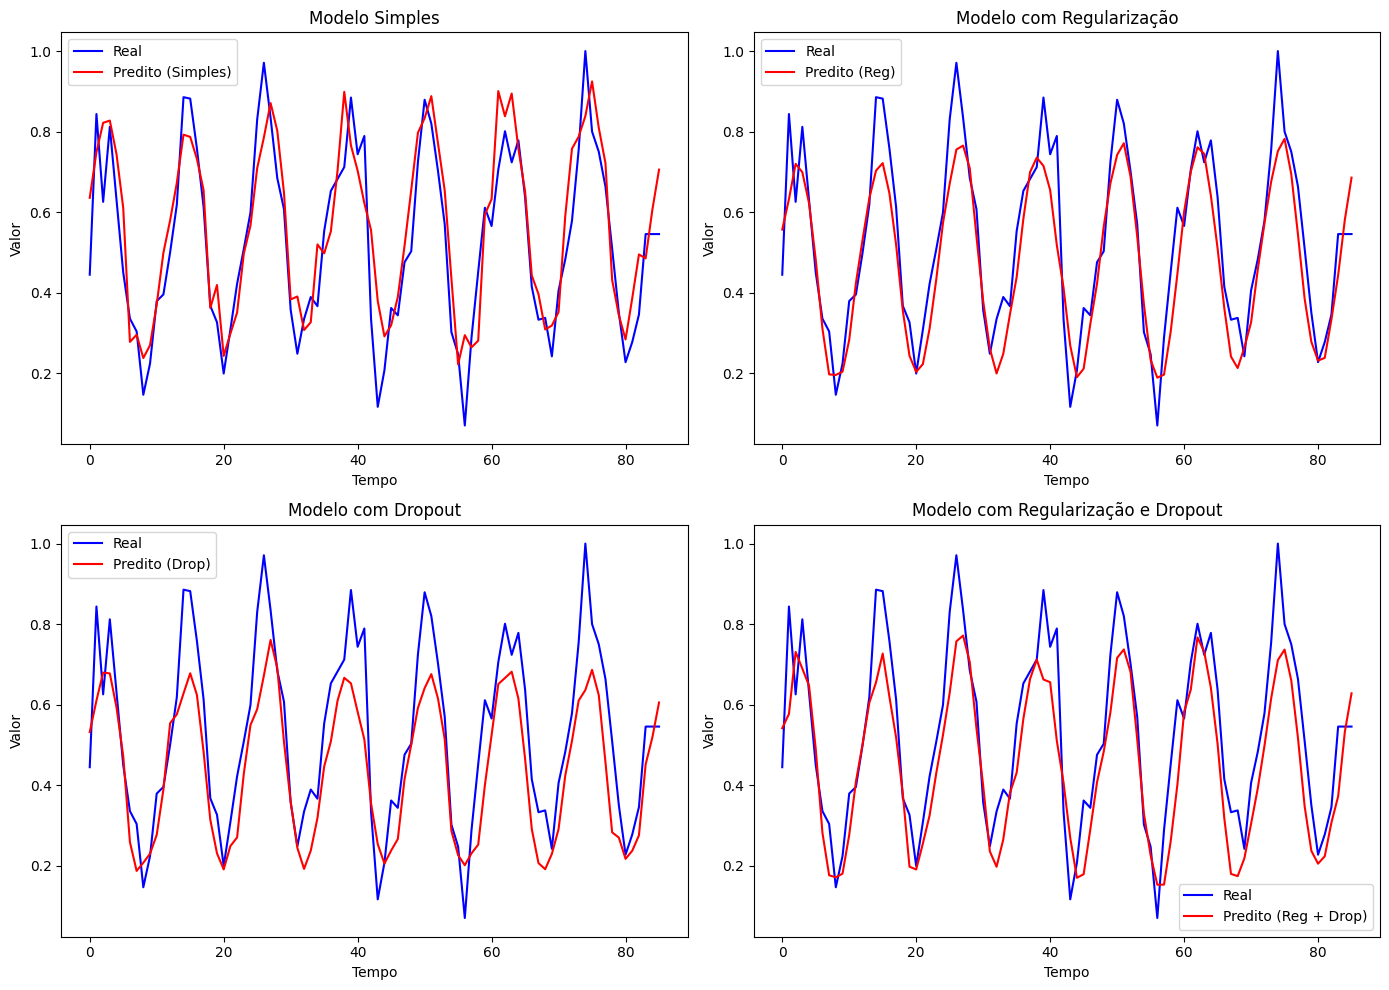

In [33]:
# Gráficos de predição
plt.figure(figsize=(14, 10))

# Modelo Simples
plt.subplot(2, 2, 1)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(y_pred_mlp, label='Predito (Simples)', color='red')
plt.title('Modelo Simples')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Regularização
plt.subplot(2, 2, 2)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(y_pred_mlp_reg, label='Predito (Reg)', color='red')
plt.title('Modelo com Regularização')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Dropout
plt.subplot(2, 2, 3)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(y_pred_mlp_drop, label='Predito (Drop)', color='red')
plt.title('Modelo com Dropout')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Regularização e Dropout
plt.subplot(2, 2, 4)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(y_pred_mlp_reg_drop, label='Predito (Reg + Drop)', color='red')
plt.title('Modelo com Regularização e Dropout')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

plt.tight_layout()
plt.show()

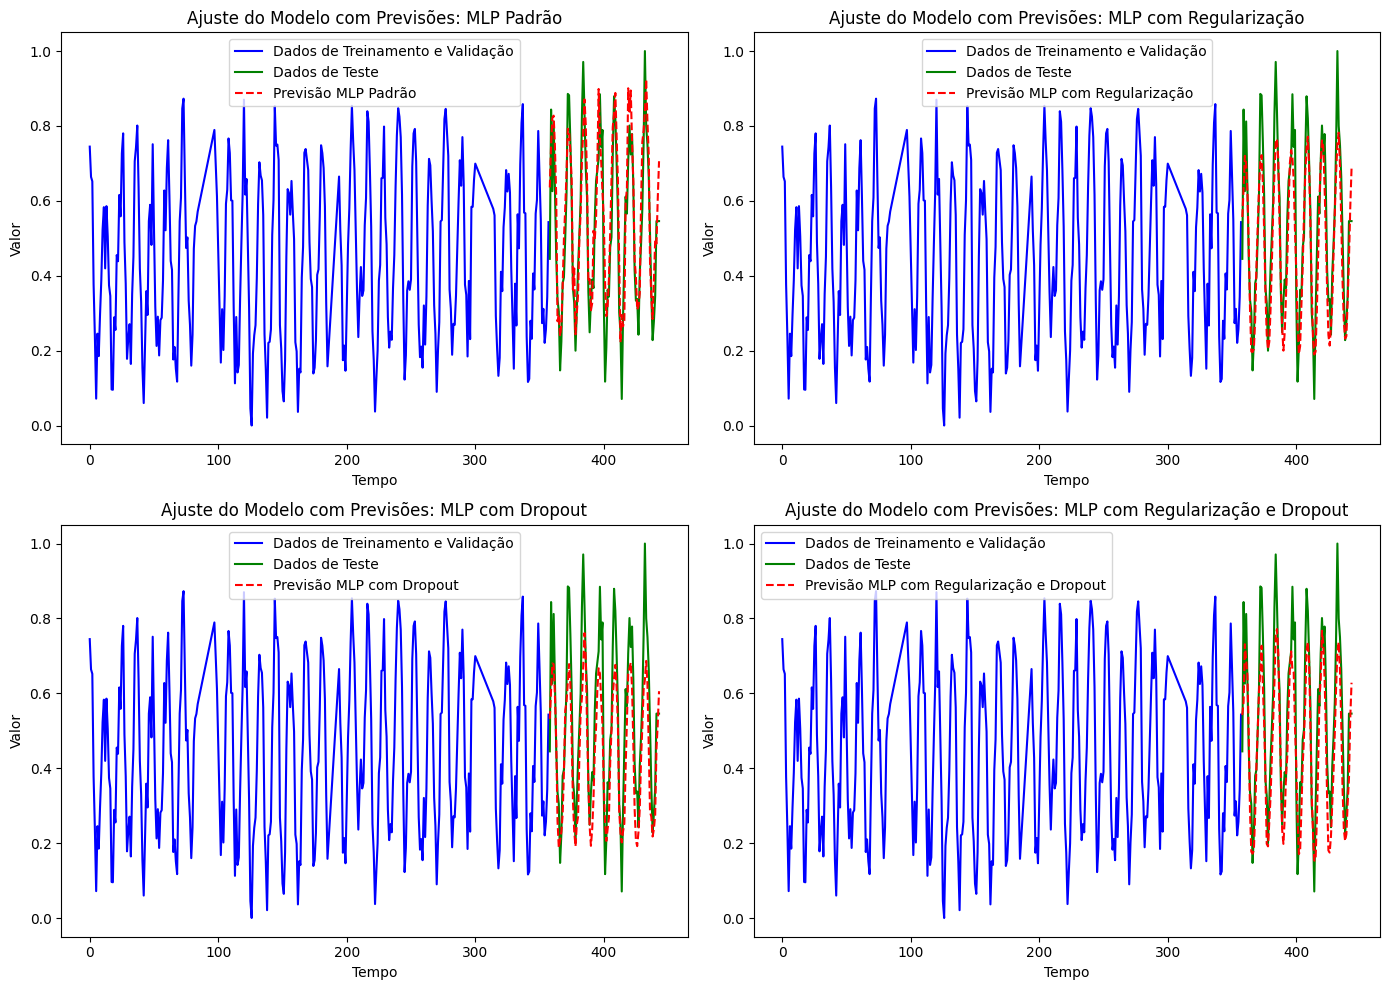

In [34]:
# Combine os dados de treino e validação em uma série para comparação visual com o conjunto de teste e previsões.
train_valid_data = np.concatenate([Y_train, Y_valid])  # Combina Y_train e Y_valid em uma série contínua

# Lista com previsões e nomes dos modelos para plotar
y_pred_models = [y_pred_mlp, y_pred_mlp_reg, y_pred_mlp_drop, y_pred_mlp_reg_drop]
model_names = ["MLP Padrão", "MLP com Regularização", "MLP com Dropout", "MLP com Regularização e Dropout"]

# Chamando a função para exibir os gráficos lado a lado
plot_multiple_predictions(train_valid_data, Y_test, y_pred_models, model_names)


# CNN for Time Series Forecasting

* For the CNN model we will use one convolutional hidden layer followed by a max pooling layer. The filter maps are then flattened before being interpreted by a Dense layer and outputting a prediction.
* The convolutional layer should be able to identify patterns between the timesteps.
* Input shape **[samples, timesteps, features]**.

#### Data preprocess
* Reshape from [samples, timesteps] into [samples, timesteps, features].
* This same reshaped data will be used on the CNN and the LSTM model.

## Seleção de Hiperparametros

In [35]:
#Hiperparametros
epochs_cnn = 30
batch_cnn = 32
lr_cnn = 0.001
#adam = optimizers.Adam(lr)


## Implementando e Ajustando Modelo CNN

In [36]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer=optimizers.Adam(lr_cnn))
# model_cnn.summary()

In [37]:
#history_cnn = model_cnn.fit(X_train_series, Y_train, 
#                            validation_data=(X_valid_series, Y_valid), 
#                            epochs=epochs_cnn, 
#                            verbose=2)

history_cnn = model_cnn.fit(X_train, 
                            Y_train, 
                            validation_data=(X_valid, Y_valid), 
                            epochs=epochs_cnn, 
                            batch_size=batch_cnn, 
                            verbose=1)

Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.1384 - val_loss: 0.0356
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0331 - val_loss: 0.0164
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0168 - val_loss: 0.0110
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0149 - val_loss: 0.0115
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0149 - val_loss: 0.0102
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0140 - val_loss: 0.0116
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0139 - val_loss: 0.0103
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0134 - val_loss: 0.0099
Epoch 9/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0132 - val_loss: 0.0097
Epoch 10/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0130 - val_loss: 0.0092
Epoch 11/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0127 - val_loss: 0.0088
Epoch 12/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0125 

## Implementando e Ajustando Modelo CNN com Regularização L2

In [38]:
model_cnn_reg = Sequential()
model_cnn_reg.add(Conv1D(filters=64, kernel_size=2, activation='relu', 
                         kernel_regularizer=regularizers.l2(0.01),  # Regularização L2
                         input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn_reg.add(MaxPooling1D(pool_size=2))
model_cnn_reg.add(Flatten())
model_cnn_reg.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_cnn_reg.add(Dense(1))
model_cnn_reg.compile(loss='mse', optimizer=optimizers.Adam(lr_cnn))
# model_cnn_reg.summary()


In [39]:
#history_cnn_reg = model_cnn_reg.fit(X_train_series, Y_train, 
#                            validation_data=(X_valid_series, Y_valid), 
#                            epochs=epochs_cnn, 
#                            verbose=2)

history_cnn_reg = model_cnn_reg.fit(X_train_series, 
                                    Y_train, 
                                    validation_data=(X_valid_series, Y_valid), 
                                    epochs=epochs_cnn, 
                                    batch_size=batch_cnn, 
                                    verbose=1)

Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 1.0650 - val_loss: 0.7210
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6513 - val_loss: 0.4826
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4368 - val_loss: 0.3285
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3093 - val_loss: 0.2454
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2351 - val_loss: 0.1969
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1898 - val_loss: 0.1631
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1593 - val_loss: 0.1392
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1374 - val_loss: 0.1213
Epoch 9/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1204 - val_loss: 0.1068
Epoch 10/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1065 - val_loss: 0.0946
Epoch 11/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0950 - val_loss: 0.0844
Epoch 12/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0852 - val_

## Implementando e Ajustando Modelo CNN com Dropout

In [40]:
model_cnn_drop = Sequential()
model_cnn_drop.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn_drop.add(MaxPooling1D(pool_size=2))
model_cnn_drop.add(Dropout(0.3))  
model_cnn_drop.add(Flatten())
model_cnn_drop.add(Dense(50, activation='relu'))
model_cnn_drop.add(Dropout(0.3))  
model_cnn_drop.add(Dense(1))
model_cnn_drop.compile(loss='mse', optimizer=optimizers.Adam(lr))
# model_cnn_drop.summary()

In [41]:
#history_cnn_drop = model_cnn_drop.fit(X_train_series, Y_train, 
#                                       validation_data=(X_valid_series, Y_valid), 
#                                       epochs=epochs_cnn, 
#                                       verbose=2)

history_cnn_drop = model_cnn_drop.fit(X_train_series, 
                                    Y_train, 
                                    validation_data=(X_valid_series, Y_valid), 
                                    epochs=epochs_cnn, 
                                    batch_size=batch_cnn, 
                                    verbose=1)

Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.1677 - val_loss: 0.0354
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0397 - val_loss: 0.0161
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0344 - val_loss: 0.0125
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0247 - val_loss: 0.0096
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0260 - val_loss: 0.0098
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0235 - val_loss: 0.0101
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0244 - val_loss: 0.0097
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0235 - val_loss: 0.0097
Epoch 9/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0233 - val_loss: 0.0100
Epoch 10/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0237 - val_loss: 0.0091
Epoch 11/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0220 - val_loss: 0.0083
Epoch 12/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.02

## Implementando e Ajustando Modelo CNN com Regularização e Dropout

In [42]:
model_cnn_reg_drop = Sequential()
model_cnn_reg_drop.add(Conv1D(filters=64, kernel_size=2, activation='relu', 
                             kernel_regularizer=regularizers.l2(0.01),
                             input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn_reg_drop.add(MaxPooling1D(pool_size=2))
model_cnn_reg_drop.add(Dropout(0.3))
model_cnn_reg_drop.add(Flatten())
model_cnn_reg_drop.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_cnn_reg_drop.add(Dropout(0.3))
model_cnn_reg_drop.add(Dense(1))
model_cnn_reg_drop.compile(loss='mse', optimizer=optimizers.Adam(lr))
# model_cnn_reg_drop.summary()

In [43]:
#history_cnn_reg_drop = model_cnn_reg_drop.fit(X_train_series, Y_train, 
#                                             validation_data=(X_valid_series, Y_valid), 
#                                             epochs=epochs_cnn, 
#                                             verbose=2)

history_cnn_reg_drop = model_cnn_reg_drop.fit(X_train_series, 
                                            Y_train, 
                                            validation_data=(X_valid_series, Y_valid), 
                                            epochs=epochs_cnn, 
                                            batch_size=batch_cnn, 
                                            verbose=1)

Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 1.0165 - val_loss: 0.6850
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6254 - val_loss: 0.4307
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4060 - val_loss: 0.2791
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2677 - val_loss: 0.1907
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1850 - val_loss: 0.1382
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1397 - val_loss: 0.1075
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1096 - val_loss: 0.0873
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0935 - val_loss: 0.0729
Epoch 9/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0775 - val_loss: 0.0622
Epoch 10/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0671 - val_loss: 0.0542
Epoch 11/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0588 - val_loss: 0.0453
Epoch 12/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0548

## Comparando os 4 Modelos CNN

In [44]:
# Previsões
y_pred_cnn = model_cnn.predict(X_test)
y_pred_cnn_reg = model_cnn_reg.predict(X_test)
y_pred_cnn_drop = model_cnn_drop.predict(X_test)
y_pred_cnn_reg_drop = model_cnn_reg_drop.predict(X_test)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


In [45]:
# Avaliação de cada modelo no conjunto de teste
mae_standard, mse_standard, rmse_standard, mape_standard = evaluate_model(model_cnn, X_test, Y_test, "Modelo Padrão")
mae_reg, mse_reg, rmse_reg, mape_reg = evaluate_model(model_cnn_reg, X_test, Y_test, "Modelo com Regularização")
mae_dropout, mse_dropout, rmse_dropout, mape_dropout = evaluate_model(model_cnn_drop, X_test, Y_test, "Modelo com Dropout")
mae_reg_drop, mse_reg_drop, rmse_reg_drop, mape_reg_drop = evaluate_model(model_cnn_reg_drop, X_test, Y_test, "Modelo com Regularização e Dropout")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Modelo Padrão:
MAE: 0.0736
MSE: 0.0083
RMSE: 0.0912
MAPE: 19.1348%
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Modelo com Regularização:
MAE: 0.0772
MSE: 0.0093
RMSE: 0.0962
MAPE: 18.4704%
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Modelo com Dropout:
MAE: 0.0739
MSE: 0.0082
RMSE: 0.0907
MAPE: 19.2565%
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Modelo com Regularização e Dropout:
MAE: 0.0704
MSE: 0.0076
RMSE: 0.0874
MAPE: 18.7441%


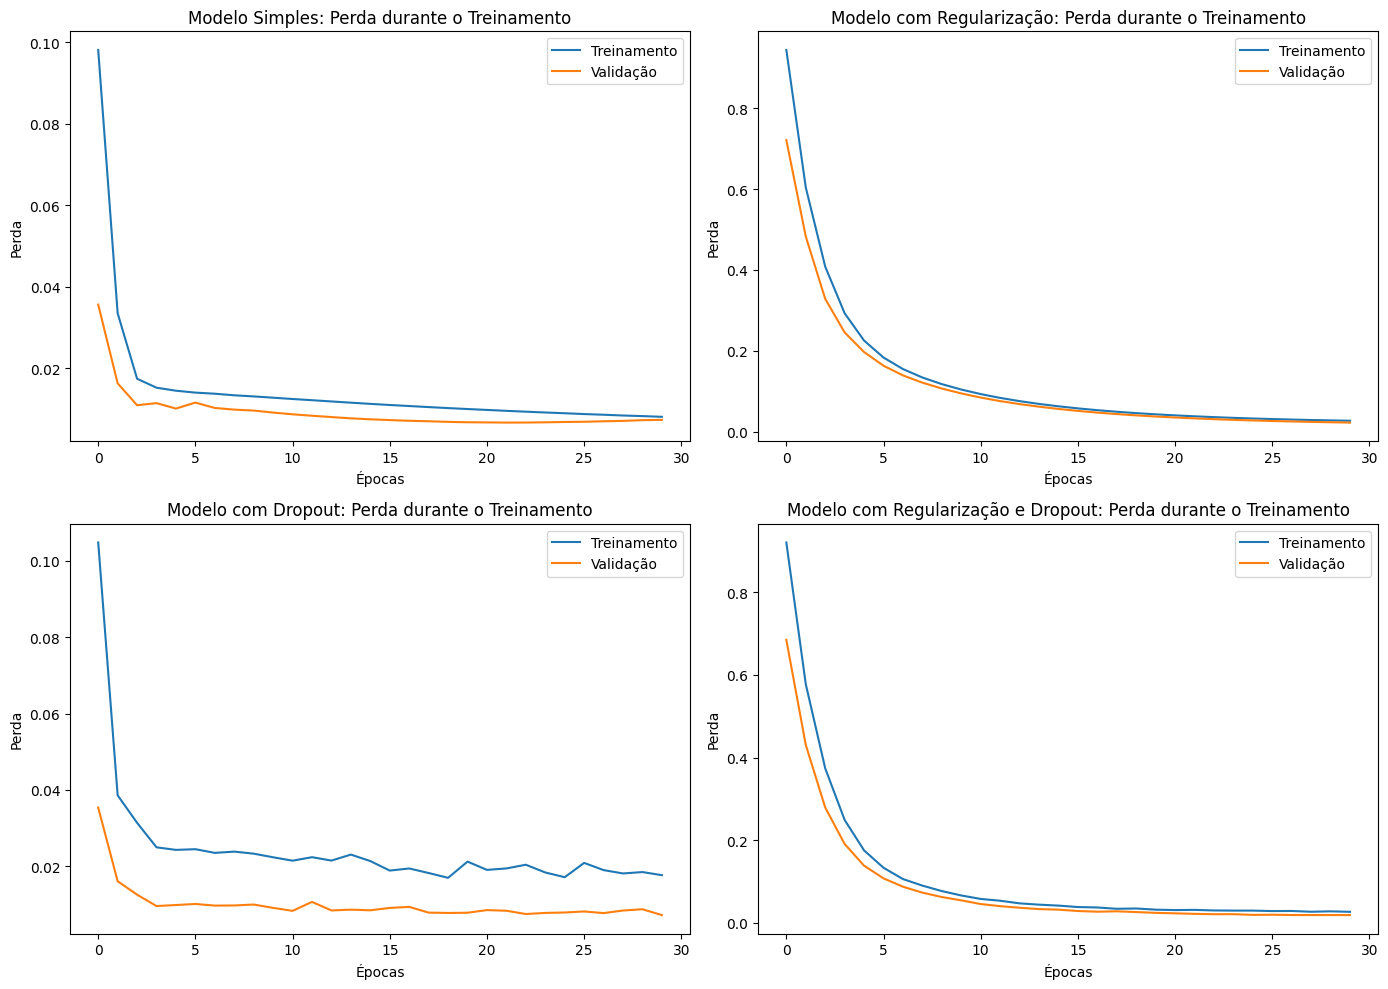

In [46]:
# Gráficos de perda durante o treinamento
plt.figure(figsize=(14, 10))

# Modelo Simples
plt.subplot(2, 2, 1)
plt.plot(history_cnn.history['loss'], label='Treinamento')
plt.plot(history_cnn.history['val_loss'], label='Validação')
plt.title('Modelo Simples: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Regularização
plt.subplot(2, 2, 2)
plt.plot(history_cnn_reg.history['loss'], label='Treinamento')
plt.plot(history_cnn_reg.history['val_loss'], label='Validação')
plt.title('Modelo com Regularização: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Dropout
plt.subplot(2, 2, 3)
plt.plot(history_cnn_drop.history['loss'], label='Treinamento')
plt.plot(history_cnn_drop.history['val_loss'], label='Validação')
plt.title('Modelo com Dropout: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Regularização e Dropout
plt.subplot(2, 2, 4)
plt.plot(history_cnn_reg_drop.history['loss'], label='Treinamento')
plt.plot(history_cnn_reg_drop.history['val_loss'], label='Validação')
plt.title('Modelo com Regularização e Dropout: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.tight_layout()
plt.show()


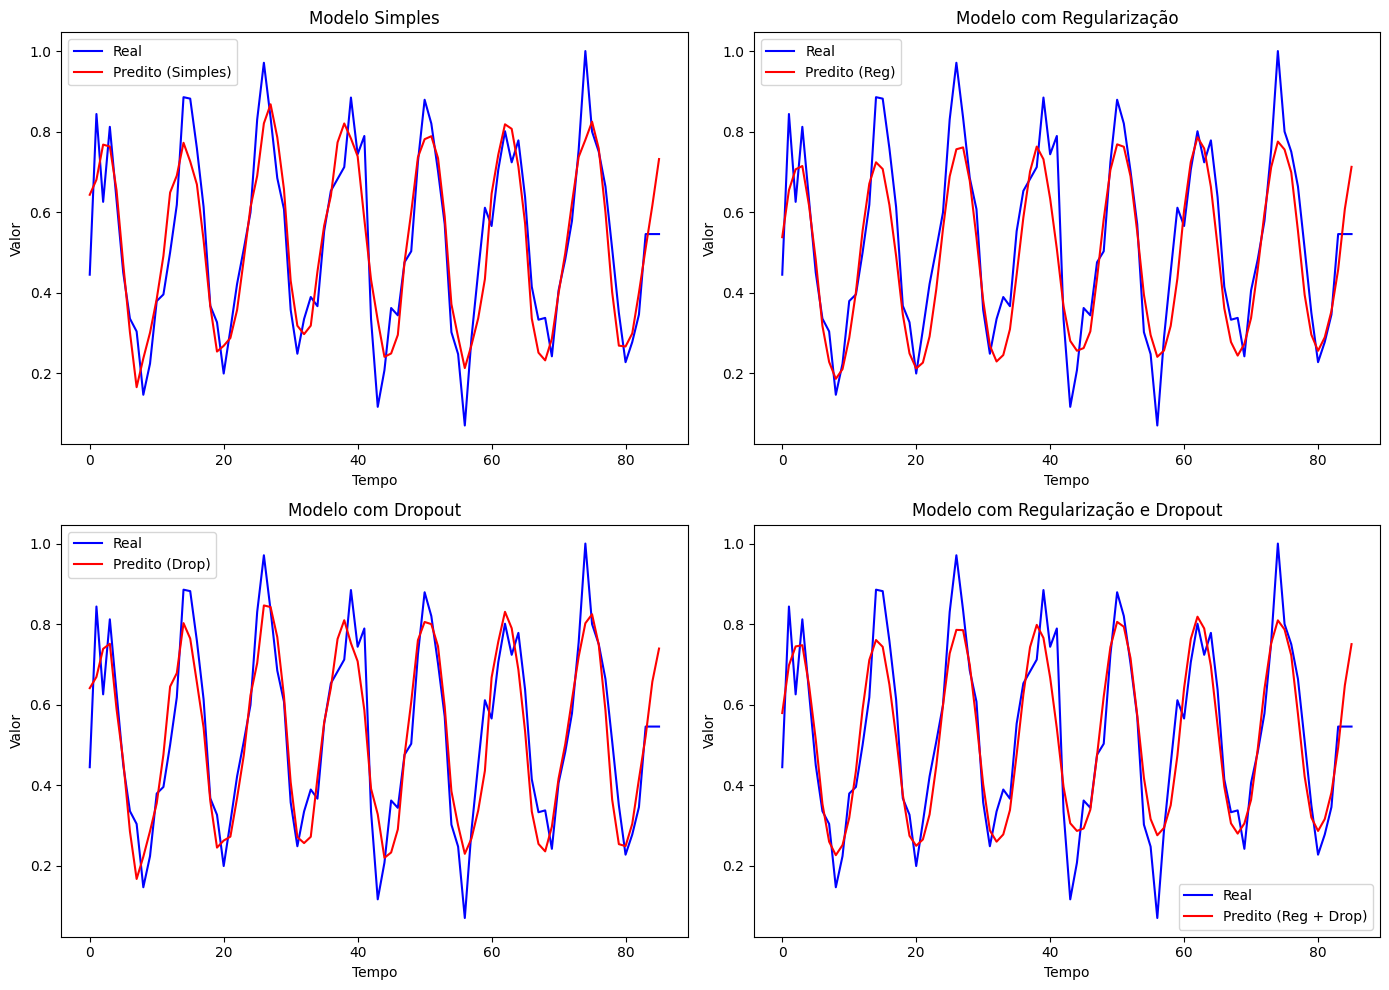

In [47]:
# Gráficos de predição
plt.figure(figsize=(14, 10))

# Modelo Simples
plt.subplot(2, 2, 1)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(y_pred_cnn, label='Predito (Simples)', color='red')
plt.title('Modelo Simples')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Regularização
plt.subplot(2, 2, 2)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(y_pred_cnn_reg, label='Predito (Reg)', color='red')
plt.title('Modelo com Regularização')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Dropout
plt.subplot(2, 2, 3)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(y_pred_cnn_drop, label='Predito (Drop)', color='red')
plt.title('Modelo com Dropout')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Regularização e Dropout
plt.subplot(2, 2, 4)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(y_pred_cnn_reg_drop, label='Predito (Reg + Drop)', color='red')
plt.title('Modelo com Regularização e Dropout')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

plt.tight_layout()
plt.show()


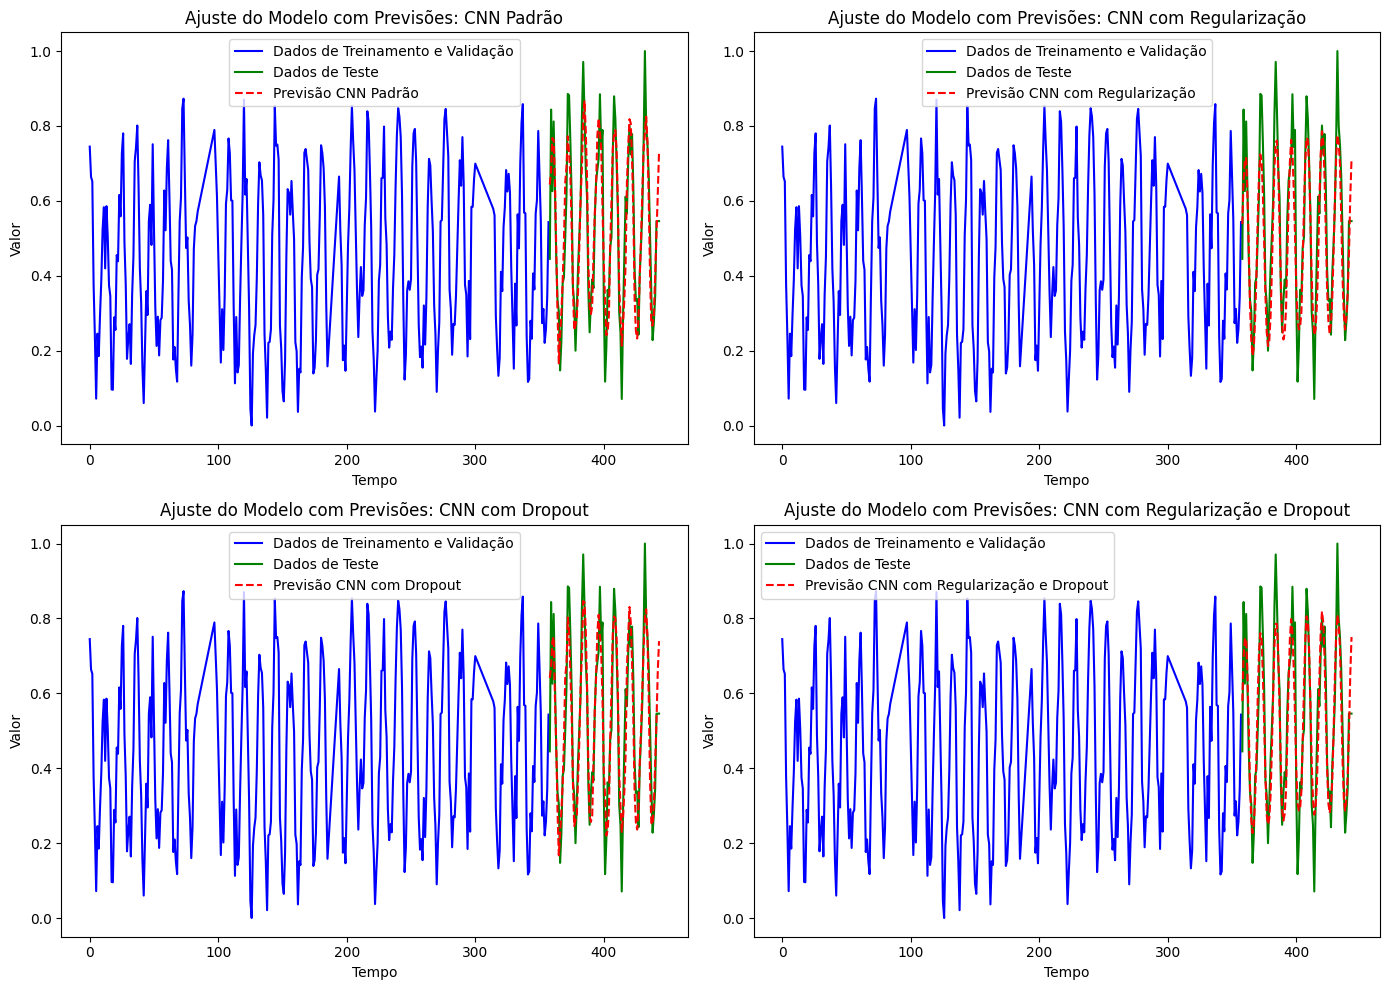

In [48]:
# Combine os dados de treino e validação em uma série para comparação visual com o conjunto de teste e previsões.
train_valid_data = np.concatenate([Y_train, Y_valid])  # Combina Y_train e Y_valid em uma série contínua

# Lista com previsões e nomes dos modelos para plotar
y_pred_models = [y_pred_cnn, y_pred_cnn_reg, y_pred_cnn_drop, y_pred_cnn_reg_drop]
model_names = ["CNN Padrão", "CNN com Regularização", "CNN com Dropout", "CNN com Regularização e Dropout"]

# Chamando a função para exibir os gráficos lado a lado
plot_multiple_predictions(train_valid_data, Y_test, y_pred_models, model_names)

# LSTM for Time Series Forecasting

* Now the LSTM model actually sees the input data as a sequence, so it's able to learn patterns from sequenced data (assuming it exists) better than the other ones, especially patterns from long sequences.
* Input shape **[samples, timesteps, features]**.

## Pre-procesamento dos dados

In [49]:
#Hiperparametros
epochs_lstm = 50
batch_lstm = 32
lr_lstm = 0.001

## Implementacao e Ajuste do Modelo LSTM

In [50]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer=optimizers.Adam(lr_lstm))
#model_lstm.summary()

In [51]:
history_lstm = model_lstm.fit(X_train_series, 
                              Y_train, 
                              validation_data=(X_valid, Y_valid), 
                              epochs=epochs_lstm,
                              batch_size = batch_lstm,
                                verbose=1)

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - loss: 0.1786 - val_loss: 0.0840
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0621 - val_loss: 0.0515
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0455 - val_loss: 0.0503
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0443 - val_loss: 0.0475
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0423 - val_loss: 0.0470
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0418 - val_loss: 0.0463
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0410 - val_loss: 0.0455
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0404 - val_loss: 0.0447
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0396 - val_loss: 0.0438
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0388 - val_loss: 0.0428
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0379 - val_loss: 0.0415
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0

## Implementacao e Ajuste do Modelo LSTM com Regularizacao L2

In [52]:
model_lstm_reg = Sequential()
model_lstm_reg.add(LSTM(50, activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm_reg.add(Dense(1))
model_lstm_reg.compile(optimizer=optimizers.Adam(lr_lstm), loss='mse')
#model_lstm_reg.summary()


In [53]:
# Treinamento do modelo com regularização L2
# history_lstm_reg = model_lstm_reg.fit(X_train_series, 
#                                       y_train, 
#                                       epochs=epochs_lstm, 
#                                       batch_size=32, 
#                                       validation_split= 0.15, 
#                                       verbose=2)

history_lstm_reg = model_lstm_reg.fit(X_train_series, 
                              Y_train, 
                              validation_data=(X_valid, Y_valid), 
                              epochs=epochs_lstm,
                              batch_size = batch_lstm,
                                verbose=1)


Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 0.2721 - val_loss: 0.1617
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1288 - val_loss: 0.0822
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0693 - val_loss: 0.0655
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0607 - val_loss: 0.0622
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0576 - val_loss: 0.0592
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0550 - val_loss: 0.0572
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0528 - val_loss: 0.0550
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0506 - val_loss: 0.0528
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0487 - val_loss: 0.0506
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0467 - val_loss: 0.0483
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0449 - val_loss: 0.0460
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0

## Implementacao e Ajuste do Modelo LSTM com Dropout

In [54]:
model_lstm_drop = Sequential()
model_lstm_drop.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm_drop.add(Dropout(0.3))
model_lstm_drop.add(Dense(1))
model_lstm_drop.compile(optimizer=optimizers.Adam(lr_lstm), loss='mse')
#model_lstm_dropout.summary()


In [55]:
# Treinamento do modelo com Dropout
history_lstm_drop = model_lstm_drop.fit(X_train_series, 
                                              Y_train, 
                                              epochs=epochs_lstm, 
                                              batch_size=batch_lstm, 
                                              validation_data=(X_valid, Y_valid), 
                                              verbose=1)


Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 0.2697 - val_loss: 0.1817
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.1661 - val_loss: 0.1042
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0861 - val_loss: 0.0477
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0529 - val_loss: 0.0478
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0537 - val_loss: 0.0489
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0512 - val_loss: 0.0467
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0492 - val_loss: 0.0465
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0467 - val_loss: 0.0460
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0490 - val_loss: 0.0455
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0467 - val_loss: 0.0448
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0494 - val_loss: 0.0444
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0

## Implementacao e Ajuste do Modelo LSTM com Regularizacao e Dropout

In [56]:
model_lstm_reg_drop = Sequential()
model_lstm_reg_drop.add(
    LSTM(
        50, 
        activation='relu', 
        kernel_regularizer=regularizers.l2(0.01),  # Regularização L2
        input_shape=(X_train_series.shape[1], X_train_series.shape[2])
    )
)
model_lstm_reg_drop.add(Dropout(0.3)) 
model_lstm_reg_drop.add(Dense(1))
model_lstm_reg_drop.compile(loss='mse', optimizer=optimizers.Adam(lr_lstm))
#model_lstm_reg_dropout.summary()


In [57]:
history_lstm_reg_drop = model_lstm_reg_drop.fit(X_train_series, 
                            Y_train, 
                            epochs=epochs_lstm,
                            batch_size=batch_lstm, 
                            validation_data=(X_valid, Y_valid),
                            verbose=2)

# history_lstm_drop = model_lstm_drop.fit(X_train_series, 
#                                               Y_train, 
#                                               epochs=epochs_lstm, 
#                                               batch_size=32, 
#                                               validation_data=(X_valid_series, Y_valid), 
#                                               verbose=1)

Epoch 1/50
11/11 - 5s - 492ms/step - loss: 0.2606 - val_loss: 0.1987
Epoch 2/50
11/11 - 0s - 29ms/step - loss: 0.1611 - val_loss: 0.0967
Epoch 3/50
11/11 - 0s - 37ms/step - loss: 0.0832 - val_loss: 0.0640
Epoch 4/50
11/11 - 0s - 31ms/step - loss: 0.0691 - val_loss: 0.0625
Epoch 5/50
11/11 - 0s - 35ms/step - loss: 0.0647 - val_loss: 0.0571
Epoch 6/50
11/11 - 1s - 62ms/step - loss: 0.0624 - val_loss: 0.0556
Epoch 7/50
11/11 - 0s - 29ms/step - loss: 0.0610 - val_loss: 0.0548
Epoch 8/50
11/11 - 1s - 48ms/step - loss: 0.0634 - val_loss: 0.0525
Epoch 9/50
11/11 - 1s - 56ms/step - loss: 0.0605 - val_loss: 0.0519
Epoch 10/50
11/11 - 1s - 59ms/step - loss: 0.0548 - val_loss: 0.0502
Epoch 11/50
11/11 - 1s - 46ms/step - loss: 0.0529 - val_loss: 0.0493
Epoch 12/50
11/11 - 1s - 77ms/step - loss: 0.0543 - val_loss: 0.0485
Epoch 13/50
11/11 - 1s - 50ms/step - loss: 0.0527 - val_loss: 0.0474
Epoch 14/50
11/11 - 0s - 34ms/step - loss: 0.0539 - val_loss: 0.0469
Epoch 15/50
11/11 - 0s - 31ms/step - loss:

## Comparativo entre os modelos - Predicao e Validacao

In [58]:
# Avaliação de cada modelo no conjunto de teste
mae_standard, mse_standard, rmse_standard, mape_standard = evaluate_model(model_lstm, X_test, Y_test, "Modelo Padrão")
mae_reg, mse_reg, rmse_reg, mape_reg = evaluate_model(model_lstm_reg, X_test, Y_test, "Modelo com Regularização")
mae_dropout, mse_dropout, rmse_dropout, mape_dropout = evaluate_model(model_lstm_drop, X_test, Y_test, "Modelo com Dropout")
mae_reg_drop, mse_reg_drop, rmse_reg_drop, mape_reg_drop = evaluate_model(model_lstm_reg_drop, X_test, Y_test, "Modelo com Regularização e Dropout")

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step

Modelo Padrão:
MAE: 0.0862
MSE: 0.0113
RMSE: 0.1064
MAPE: 19.7338%
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step

Modelo com Regularização:
MAE: 0.0773
MSE: 0.0094
RMSE: 0.0969
MAPE: 18.1175%
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step

Modelo com Dropout:
MAE: 0.1003
MSE: 0.0163
RMSE: 0.1278
MAPE: 23.9673%
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step

Modelo com Regularização e Dropout:
MAE: 0.1153
MSE: 0.0214
RMSE: 0.1462
MAPE: 26.4528%


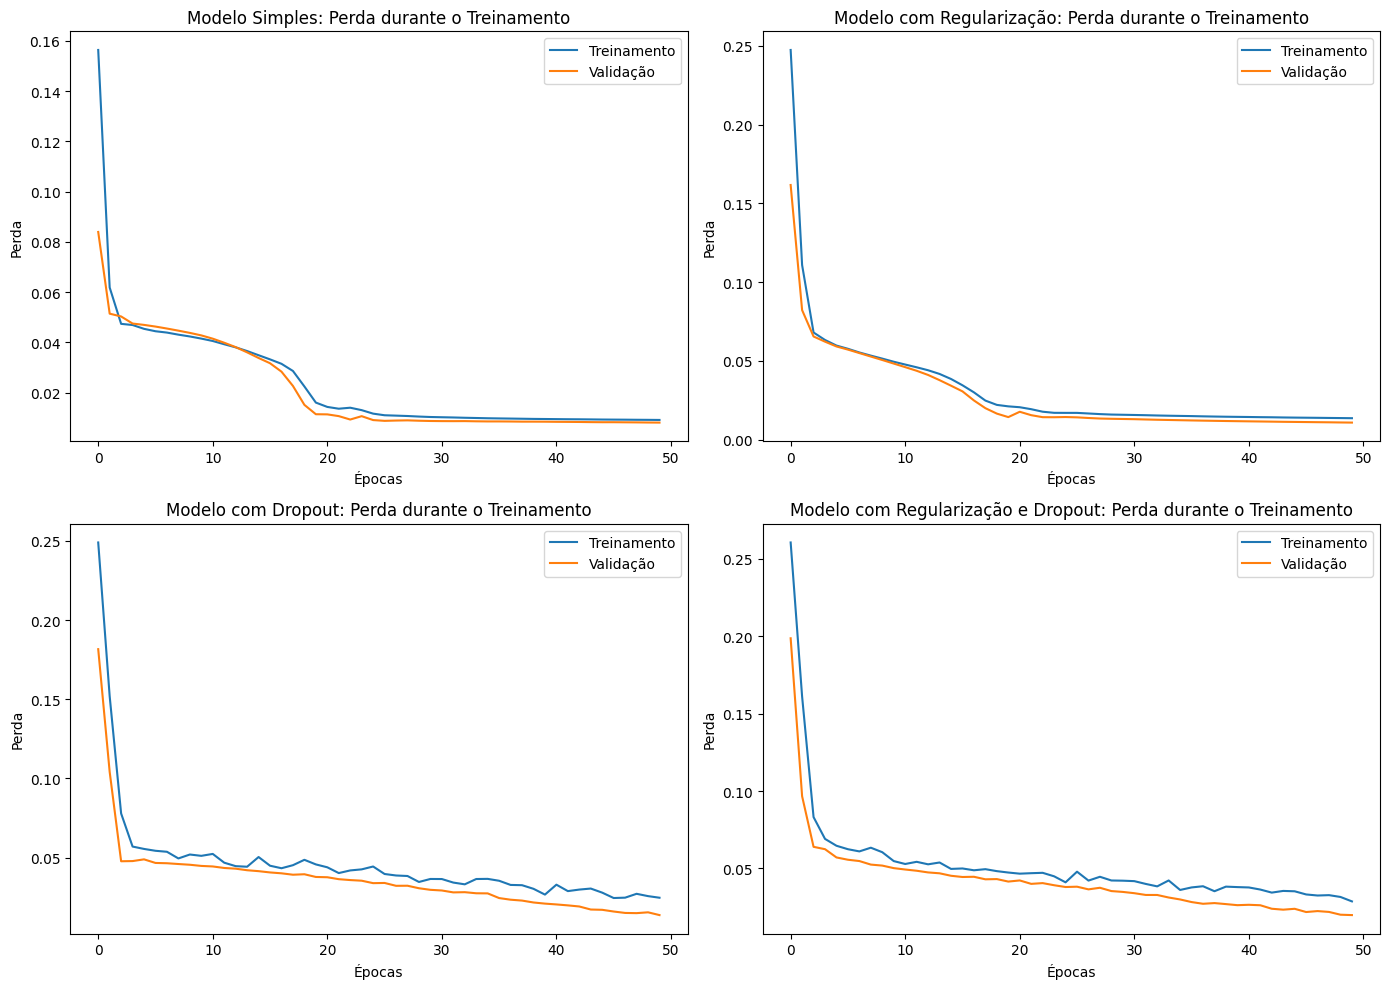

In [59]:
# Gráficos de perda durante o treinamento
plt.figure(figsize=(14, 10))

# Modelo Simples
plt.subplot(2, 2, 1)
plt.plot(history_lstm.history['loss'], label='Treinamento')
plt.plot(history_lstm.history['val_loss'], label='Validação')
plt.title('Modelo Simples: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Regularização
plt.subplot(2, 2, 2)
plt.plot(history_lstm_reg.history['loss'], label='Treinamento')
plt.plot(history_lstm_reg.history['val_loss'], label='Validação')
plt.title('Modelo com Regularização: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Dropout
plt.subplot(2, 2, 3)
plt.plot(history_lstm_drop.history['loss'], label='Treinamento')
plt.plot(history_lstm_drop.history['val_loss'], label='Validação')
plt.title('Modelo com Dropout: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Regularização e Dropout
plt.subplot(2, 2, 4)
plt.plot(history_lstm_reg_drop.history['loss'], label='Treinamento')
plt.plot(history_lstm_reg_drop.history['val_loss'], label='Validação')
plt.title('Modelo com Regularização e Dropout: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.tight_layout()
plt.show()

In [60]:
# Obtendo as previsões dos quatro modelos
y_pred_lstm = model_lstm.predict(X_test)
y_pred_lstm_reg = model_lstm_reg.predict(X_test)
y_pred_lstm_drop = model_lstm_drop.predict(X_test)
y_pred_lstm_reg_drop = model_lstm_reg_drop.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


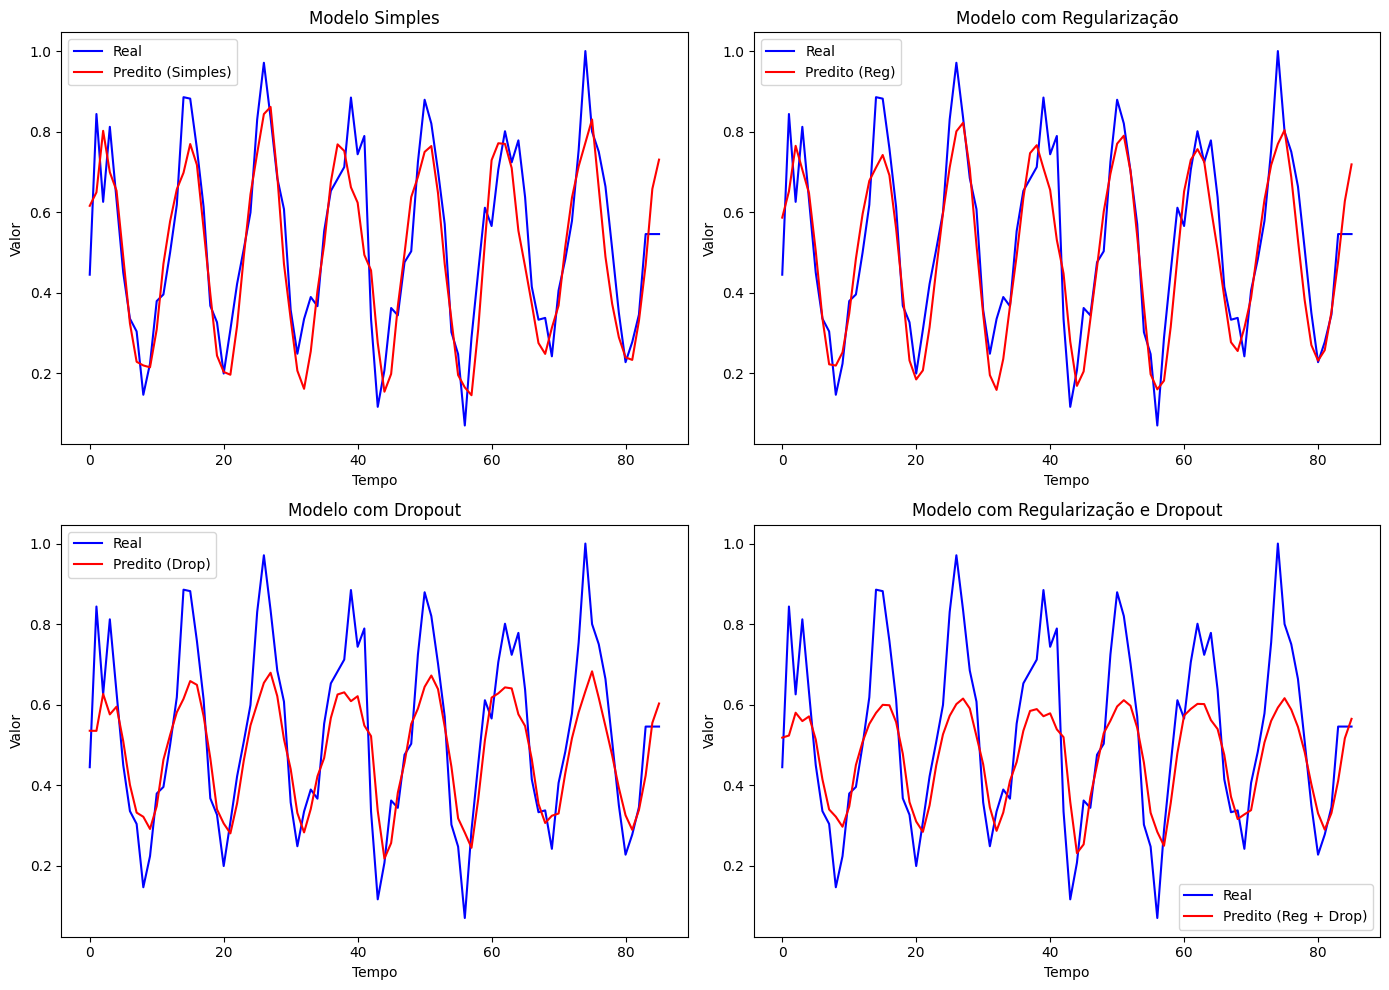

In [61]:
# Gráficos de predição
plt.figure(figsize=(14, 10))

# Modelo Simples
plt.subplot(2, 2, 1)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(y_pred_lstm, label='Predito (Simples)', color='red')
plt.title('Modelo Simples')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Regularização
plt.subplot(2, 2, 2)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(y_pred_lstm_reg, label='Predito (Reg)', color='red')
plt.title('Modelo com Regularização')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Dropout
plt.subplot(2, 2, 3)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(y_pred_lstm_drop, label='Predito (Drop)', color='red')
plt.title('Modelo com Dropout')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Regularização e Dropout
plt.subplot(2, 2, 4)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(y_pred_lstm_reg_drop, label='Predito (Reg + Drop)', color='red')
plt.title('Modelo com Regularização e Dropout')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

plt.tight_layout()
plt.show()


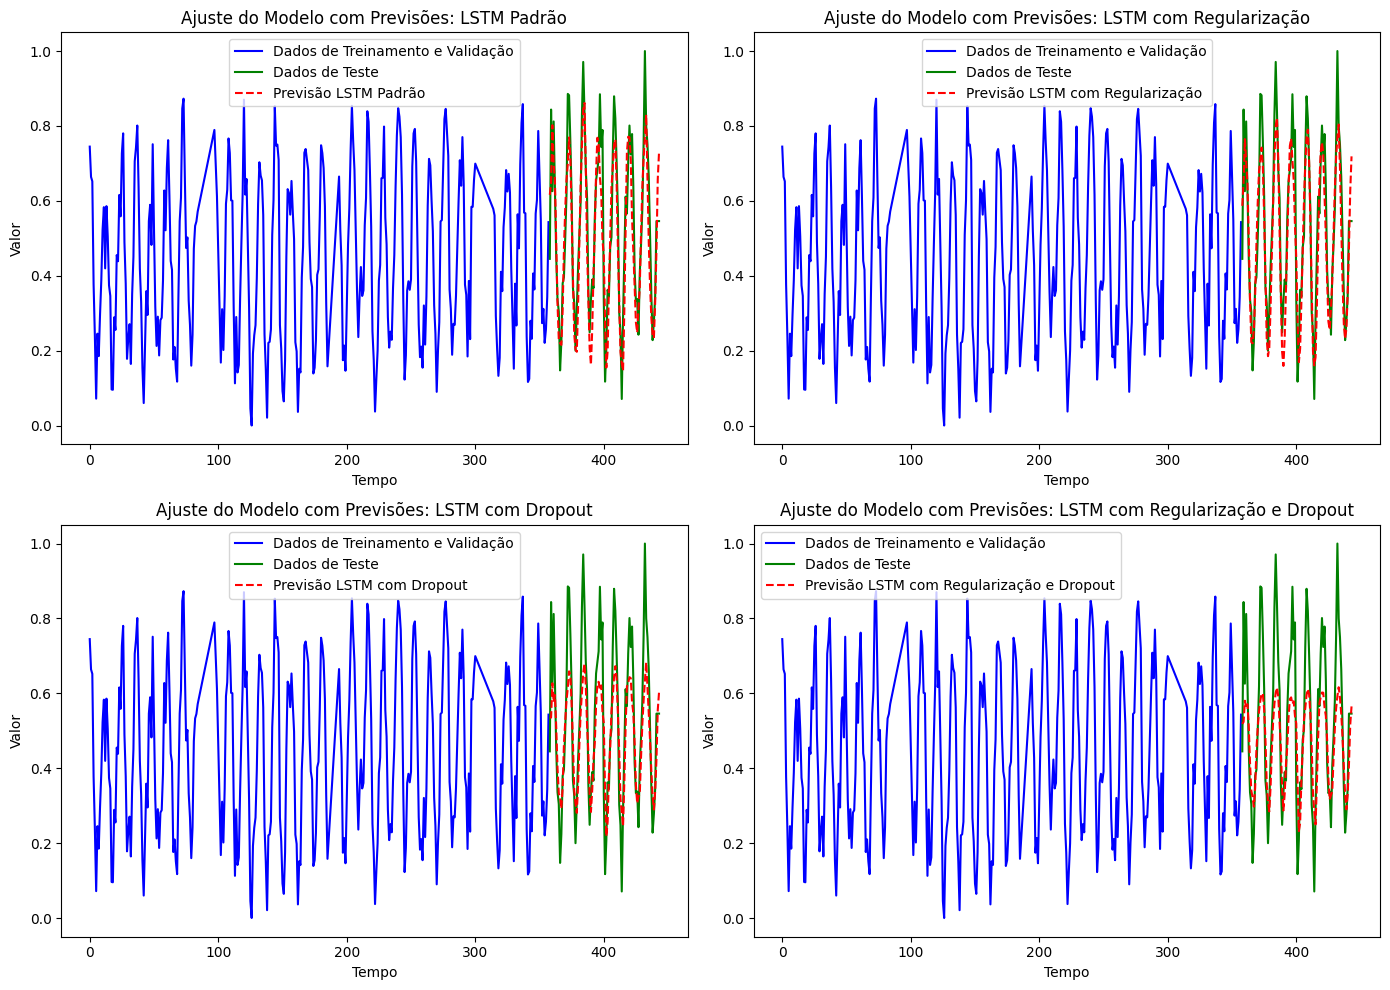

In [62]:
# Combine os dados de treino e validação em uma série para comparação visual com o conjunto de teste e previsões.
train_valid_data = np.concatenate([Y_train, Y_valid])  # Combina Y_train e Y_valid em uma série contínua

# Lista com previsões e nomes dos modelos para plotar
y_pred_models = [y_pred_lstm, y_pred_lstm_reg, y_pred_lstm_drop, y_pred_lstm_reg_drop]
model_names = ["LSTM Padrão", "LSTM com Regularização", "LSTM com Dropout", "LSTM com Regularização e Dropout"]

# Chamando a função para exibir os gráficos lado a lado
plot_multiple_predictions(train_valid_data, Y_test, y_pred_models, model_names)

# CNN-LSTM for Time Series Forecasting
* Input shape **[samples, subsequences, timesteps, features]**.

#### Model explanation from the [article](https://machinelearningmastery.com/how-to-get-started-with-deep-learning-for-time-series-forecasting-7-day-mini-course/)
> "The benefit of this model is that the model can support very long input sequences that can be read as blocks or subsequences by the CNN model, then pieced together by the LSTM model."
>
> "When using a hybrid CNN-LSTM model, we will further divide each sample into further subsequences. The CNN model will interpret each sub-sequence and the LSTM will piece together the interpretations from the subsequences. As such, we will split each sample into 2 subsequences of 2 times per subsequence."
>
> "The CNN will be defined to expect 2 timesteps per subsequence with one feature. The entire CNN model is then wrapped in TimeDistributed wrapper layers so that it can be applied to each subsequence in the sample. The results are then interpreted by the LSTM layer before the model outputs a prediction."

#### Data preprocess
* Reshape from [samples, timesteps, features] into [samples, subsequences, timesteps, features].

## Pre-processamento dos dados

In [63]:
#Hiperparametros
epochs_hibrid = 30
batch_hibrid = 32
lr_hibrid = 0.001
subsequences = 2

In [64]:
timesteps = X_train.shape[1]//subsequences
X_train_series_sub = X_train.reshape((X_train.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = X_valid.reshape((X_valid.shape[0], subsequences, timesteps, 1))
X_test_series_sub = X_test.reshape((X_test.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)
print('Test set shape', X_test_series_sub.shape)

Train set shape (334, 2, 30, 1)
Validation set shape (24, 2, 30, 1)
Test set shape (86, 2, 30, 1)


## Implementacao e ajuste do modelo padrao

In [65]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(50, activation='relu'))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss='mse', optimizer=optimizers.Adam(lr_hibrid))

In [66]:
history_cnn_lstm = model_cnn_lstm.fit(X_train_series_sub, 
                                      Y_train, 
                                      validation_data=(X_valid_series_sub, Y_valid), 
                                      epochs=epochs_hibrid,
                                      batch_size = batch_hibrid, 
                                      verbose=1)

Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 0.1672 - val_loss: 0.0849
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0559 - val_loss: 0.0413
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0419 - val_loss: 0.0403
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0365 - val_loss: 0.0275
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0303 - val_loss: 0.0213
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0238 - val_loss: 0.0130
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0165 - val_loss: 0.0123
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0140 - val_loss: 0.0146
Epoch 9/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0142 - val_loss: 0.0123
Epoch 10/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0136 - val_loss: 0.0113
Epoch 11/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0133 - val_loss: 0.0111
Epoch 12/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0

## Implementacao e Ajuste do modelo com Regularizacao

In [67]:
model_cnn_lstm_reg = Sequential()
model_cnn_lstm_reg.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu', kernel_regularizer=regularizers.l2(0.001)), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm_reg.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model_cnn_lstm_reg.add(TimeDistributed(Flatten()))
model_cnn_lstm_reg.add(LSTM(50, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn_lstm_reg.add(Dense(1))
model_cnn_lstm_reg.compile(loss='mse', optimizer=optimizers.Adam(lr_hibrid))

In [68]:
history_cnn_lstm_reg = model_cnn_lstm_reg.fit(X_train_series_sub, 
                                              Y_train, 
                                              validation_data=(X_valid_series_sub, Y_valid), 
                                              epochs=epochs_hibrid, 
                                              batch_size = batch_hibrid,
                                              verbose=1)


Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - loss: 0.4428 - val_loss: 0.2482
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2295 - val_loss: 0.1482
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1348 - val_loss: 0.0890
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0854 - val_loss: 0.0584
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0572 - val_loss: 0.0432
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0445 - val_loss: 0.0375
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0392 - val_loss: 0.0322
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0352 - val_loss: 0.0292
Epoch 9/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0324 - val_loss: 0.0278
Epoch 10/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0302 - val_loss: 0.0259
Epoch 11/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0283 - val_loss: 0.0244
Epoch 12/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0

## Implementacao e Ajuste do Modelo com Dropout

In [69]:
model_cnn_lstm_drop = Sequential()
model_cnn_lstm_drop.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm_drop.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model_cnn_lstm_drop.add(TimeDistributed(Flatten()))
model_cnn_lstm_drop.add(Dropout(0.3))
model_cnn_lstm_drop.add(LSTM(50, activation='relu'))
model_cnn_lstm_drop.add(Dropout(0.3))
model_cnn_lstm_drop.add(Dense(1))
model_cnn_lstm_drop.compile(loss='mse', optimizer=optimizers.Adam(lr_hibrid))

In [70]:
history_cnn_lstm_drop = model_cnn_lstm_drop.fit(X_train_series_sub, 
                                                Y_train, 
                                                validation_data=(X_valid_series_sub, Y_valid), 
                                                epochs=epochs_hibrid, 
                                                batch_size = batch_hibrid,
                                                verbose=1)


Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - loss: 0.1335 - val_loss: 0.0508
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0564 - val_loss: 0.0429
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0477 - val_loss: 0.0228
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0311 - val_loss: 0.0158
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0264 - val_loss: 0.0110
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0207 - val_loss: 0.0086
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0167 - val_loss: 0.0092
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0182 - val_loss: 0.0102
Epoch 9/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0161 - val_loss: 0.0083
Epoch 10/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0176 - val_loss: 0.0091
Epoch 11/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0166 - val_loss: 0.0081
Epoch 12/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0

## Implementacao e Ajuste do Modelo com Regularizacao e Dropout

In [71]:
model_cnn_lstm_reg_drop = Sequential()
model_cnn_lstm_reg_drop.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu', kernel_regularizer=regularizers.l2(0.001)), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm_reg_drop.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model_cnn_lstm_reg_drop.add(TimeDistributed(Flatten()))
model_cnn_lstm_reg_drop.add(Dropout(0.3))
model_cnn_lstm_reg_drop.add(LSTM(50, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn_lstm_reg_drop.add(Dropout(0.3))
model_cnn_lstm_reg_drop.add(Dense(1))
model_cnn_lstm_reg_drop.compile(loss='mse', optimizer=optimizers.Adam(lr_hibrid))

history_cnn_lstm_reg_drop = model_cnn_lstm_reg_drop.fit(X_train_series_sub, 
                                                        Y_train, 
                                                        validation_data=(X_valid_series_sub, Y_valid), 
                                                        epochs=epochs_hibrid, 
                                                        batch_size = batch_hibrid,
                                                        verbose=1)


Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - loss: 0.4306 - val_loss: 0.2684
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.2462 - val_loss: 0.1625
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1558 - val_loss: 0.1025
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1066 - val_loss: 0.0716
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0776 - val_loss: 0.0568
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0634 - val_loss: 0.0471
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0590 - val_loss: 0.0436
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0561 - val_loss: 0.0402
Epoch 9/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0481 - val_loss: 0.0357
Epoch 10/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0441 - val_loss: 0.0333
Epoch 11/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0419 - val_loss: 0.0318
Epoch 12/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0

## Comparativo entre os modelos

In [72]:
# Realizando previsões para cada modelo
y_pred_cnn_lstm = model_cnn_lstm.predict(X_test_series_sub)
y_pred_cnn_lstm_reg = model_cnn_lstm_reg.predict(X_test_series_sub)
y_pred_cnn_lstm_drop = model_cnn_lstm_drop.predict(X_test_series_sub)
y_pred_cnn_lstm_reg_drop = model_cnn_lstm_reg_drop.predict(X_test_series_sub)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 246ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step


In [73]:
# # Cálculo das métricas para cada modelo
# metrics = {
#     "Modelo LSTM": {
#         "MAPE": mean_absolute_percentage_error(Y_test, y_pred_cnn_lstm),
#         "MSE": mean_squared_error(Y_test, y_pred_cnn_lstm),
#         "RMSE": root_mean_squared_error(Y_test, y_pred_cnn_lstm)
#     },
#     "Modelo LSTM com Regularização": {
#         "MAPE": mean_absolute_percentage_error(Y_test, y_pred_cnn_lstm_reg),
#         "MSE": mean_squared_error(Y_test, y_pred_cnn_lstm_reg),
#         "RMSE": root_mean_squared_error(Y_test, y_pred_cnn_lstm_reg)
#     },
#     "Modelo LSTM com Dropout": {
#         "MAPE": mean_absolute_percentage_error(Y_test, y_pred_cnn_lstm_drop),
#         "MSE": mean_squared_error(Y_test, y_pred_cnn_lstm_drop),
#         "RMSE": root_mean_squared_error(Y_test, y_pred_cnn_lstm_drop)
#     },
#     "Modelo LSTM com Regularização e Dropout": {
#         "MAPE": mean_absolute_percentage_error(Y_test, y_pred_cnn_lstm_reg_drop),
#         "MSE": mean_squared_error(Y_test, y_pred_cnn_lstm_reg_drop),
#         "RMSE": root_mean_squared_error(Y_test, y_pred_cnn_lstm_reg_drop)
#     }
# }

# # Exibir as métricas
# for model, values in metrics.items():
#     print(f"{model}: MAPE={values['MAPE']:.2f}%, MSE={values['MSE']:.4f}, RMSE={values['RMSE']:.4f}")

In [74]:
# Avaliação de cada modelo no conjunto de teste
mae_standard, mse_standard, rmse_standard, mape_standard = evaluate_model(model_cnn_lstm, X_test_series_sub, Y_test, "Modelo Padrão")
mae_reg, mse_reg, rmse_reg, mape_reg = evaluate_model(model_cnn_lstm_reg, X_test_series_sub, Y_test, "Modelo com Regularização")
mae_dropout, mse_dropout, rmse_dropout, mape_dropout = evaluate_model(model_cnn_lstm_drop, X_test_series_sub, Y_test, "Modelo com Dropout")
mae_reg_drop, mse_reg_drop, rmse_reg_drop, mape_reg_drop = evaluate_model(model_cnn_lstm_reg_drop, X_test_series_sub, Y_test, "Modelo com Regularização e Dropout")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  

Modelo Padrão:
MAE: 0.0844
MSE: 0.0106
RMSE: 0.1027
MAPE: 20.0712%
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Modelo com Regularização:
MAE: 0.0797
MSE: 0.0093
RMSE: 0.0967
MAPE: 18.5494%
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Modelo com Dropout:
MAE: 0.0795
MSE: 0.0098
RMSE: 0.0988
MAPE: 18.3343%
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Modelo com Regularização e Dropout:
MAE: 0.0741
MSE: 0.0087
RMSE: 0.0931
MAPE: 17.9579%


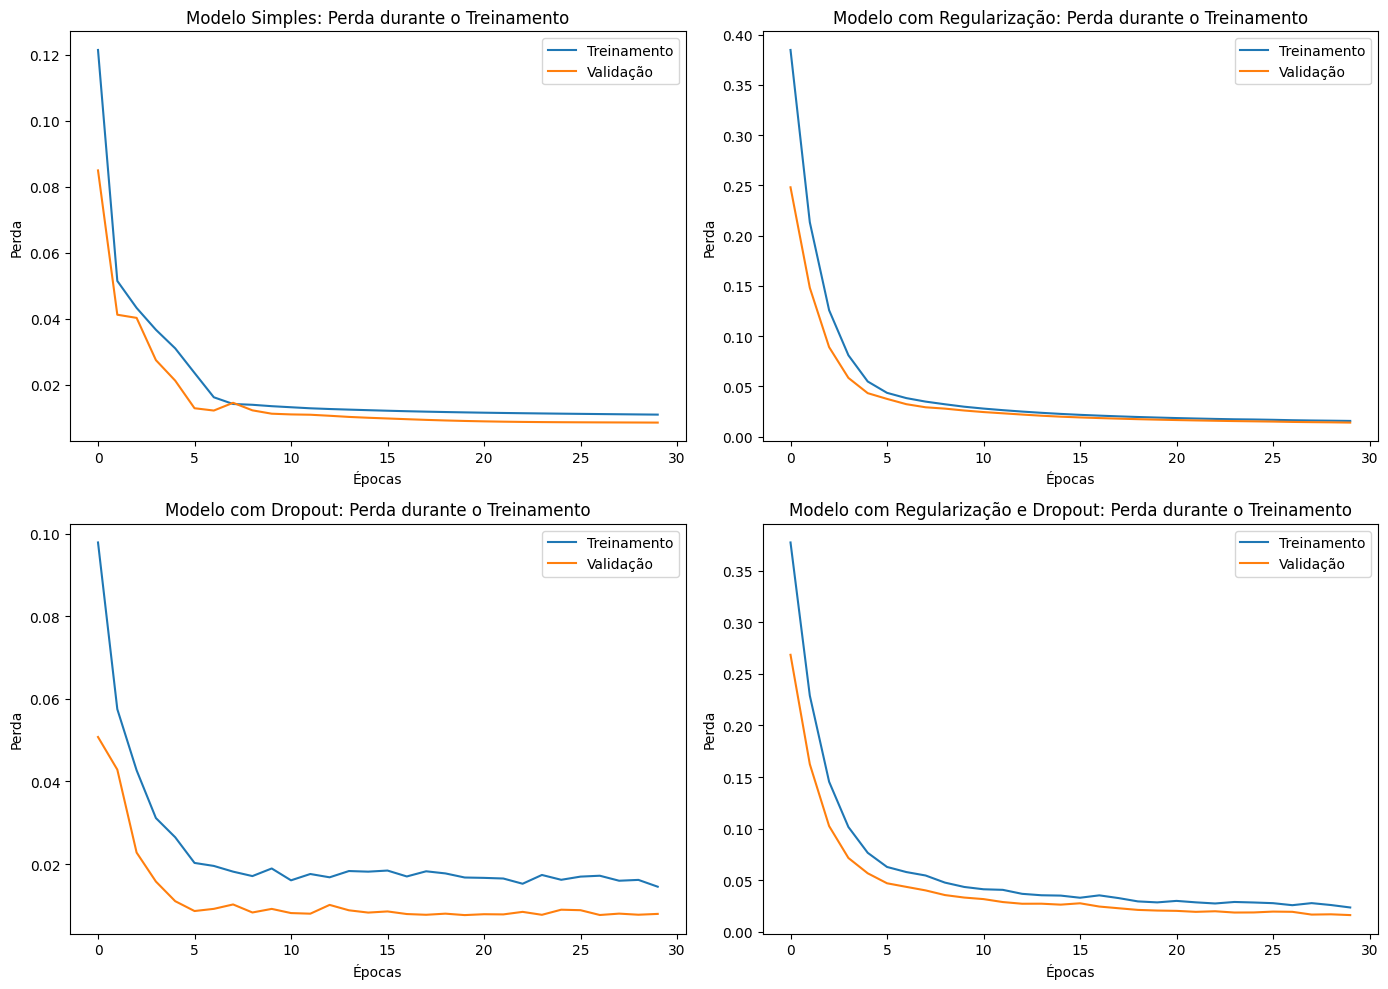

In [75]:
# Gráficos de perda durante o treinamento
plt.figure(figsize=(14, 10))

# Modelo Simples
plt.subplot(2, 2, 1)
plt.plot(history_cnn_lstm.history['loss'], label='Treinamento')
plt.plot(history_cnn_lstm.history['val_loss'], label='Validação')
plt.title('Modelo Simples: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Regularização
plt.subplot(2, 2, 2)
plt.plot(history_cnn_lstm_reg.history['loss'], label='Treinamento')
plt.plot(history_cnn_lstm_reg.history['val_loss'], label='Validação')
plt.title('Modelo com Regularização: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Dropout
plt.subplot(2, 2, 3)
plt.plot(history_cnn_lstm_drop.history['loss'], label='Treinamento')
plt.plot(history_cnn_lstm_drop.history['val_loss'], label='Validação')
plt.title('Modelo com Dropout: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Regularização e Dropout
plt.subplot(2, 2, 4)
plt.plot(history_cnn_lstm_reg_drop.history['loss'], label='Treinamento')
plt.plot(history_cnn_lstm_reg_drop.history['val_loss'], label='Validação')
plt.title('Modelo com Regularização e Dropout: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.tight_layout()
plt.show()

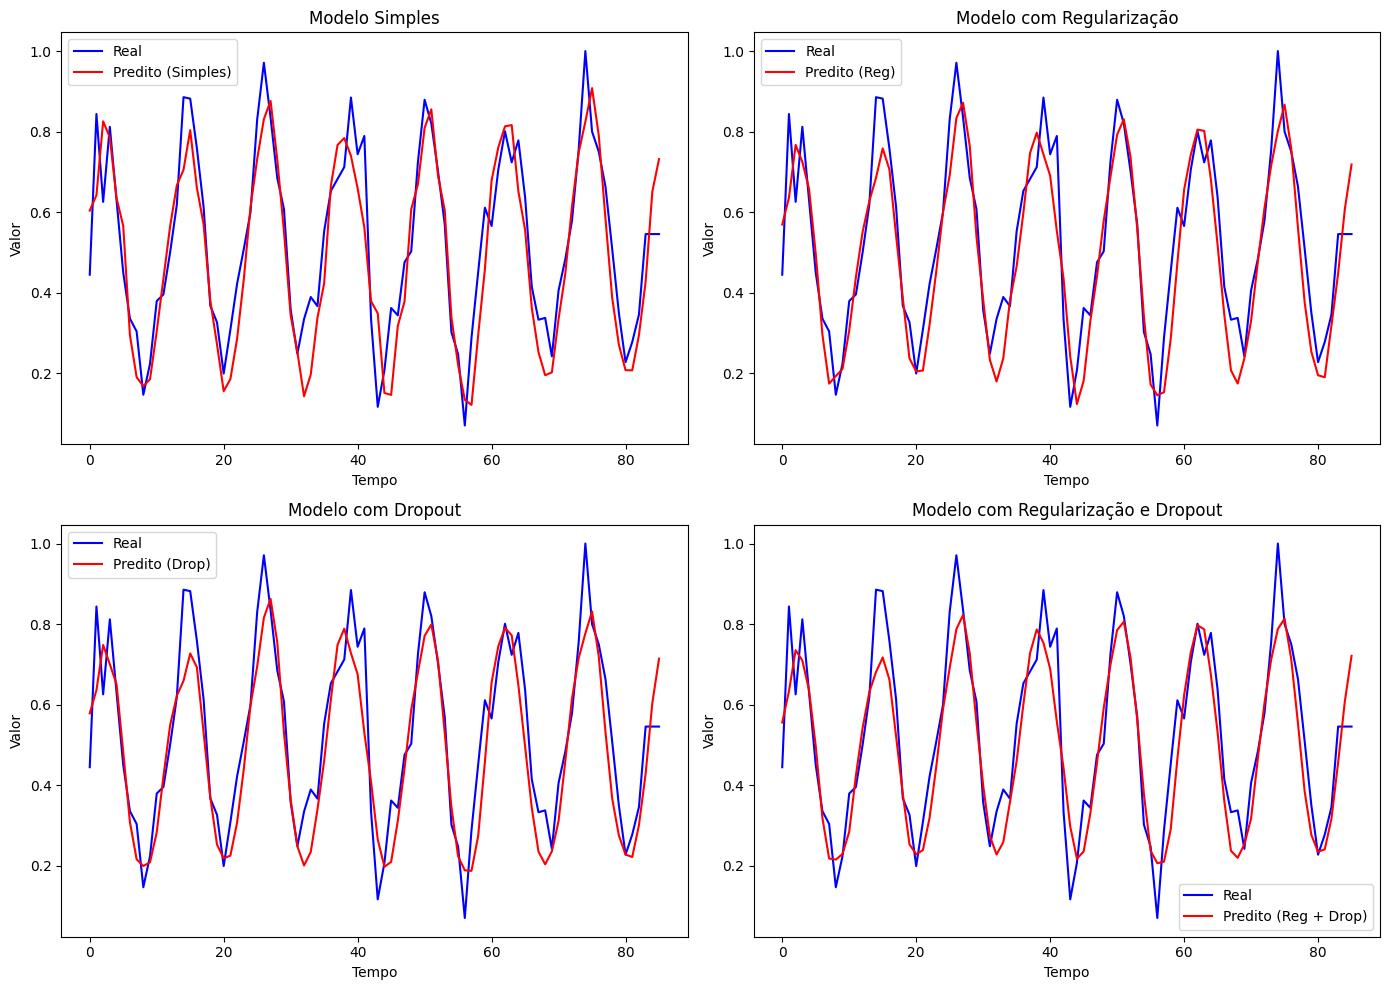

In [76]:
# Gráficos de predição
plt.figure(figsize=(14, 10))

# Modelo Simples
plt.subplot(2, 2, 1)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(y_pred_cnn_lstm, label='Predito (Simples)', color='red')
plt.title('Modelo Simples')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Regularização
plt.subplot(2, 2, 2)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(y_pred_cnn_lstm_reg, label='Predito (Reg)', color='red')
plt.title('Modelo com Regularização')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Dropout
plt.subplot(2, 2, 3)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(y_pred_cnn_lstm_drop, label='Predito (Drop)', color='red')
plt.title('Modelo com Dropout')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Regularização e Dropout
plt.subplot(2, 2, 4)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(y_pred_cnn_lstm_reg_drop, label='Predito (Reg + Drop)', color='red')
plt.title('Modelo com Regularização e Dropout')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

plt.tight_layout()
plt.show()

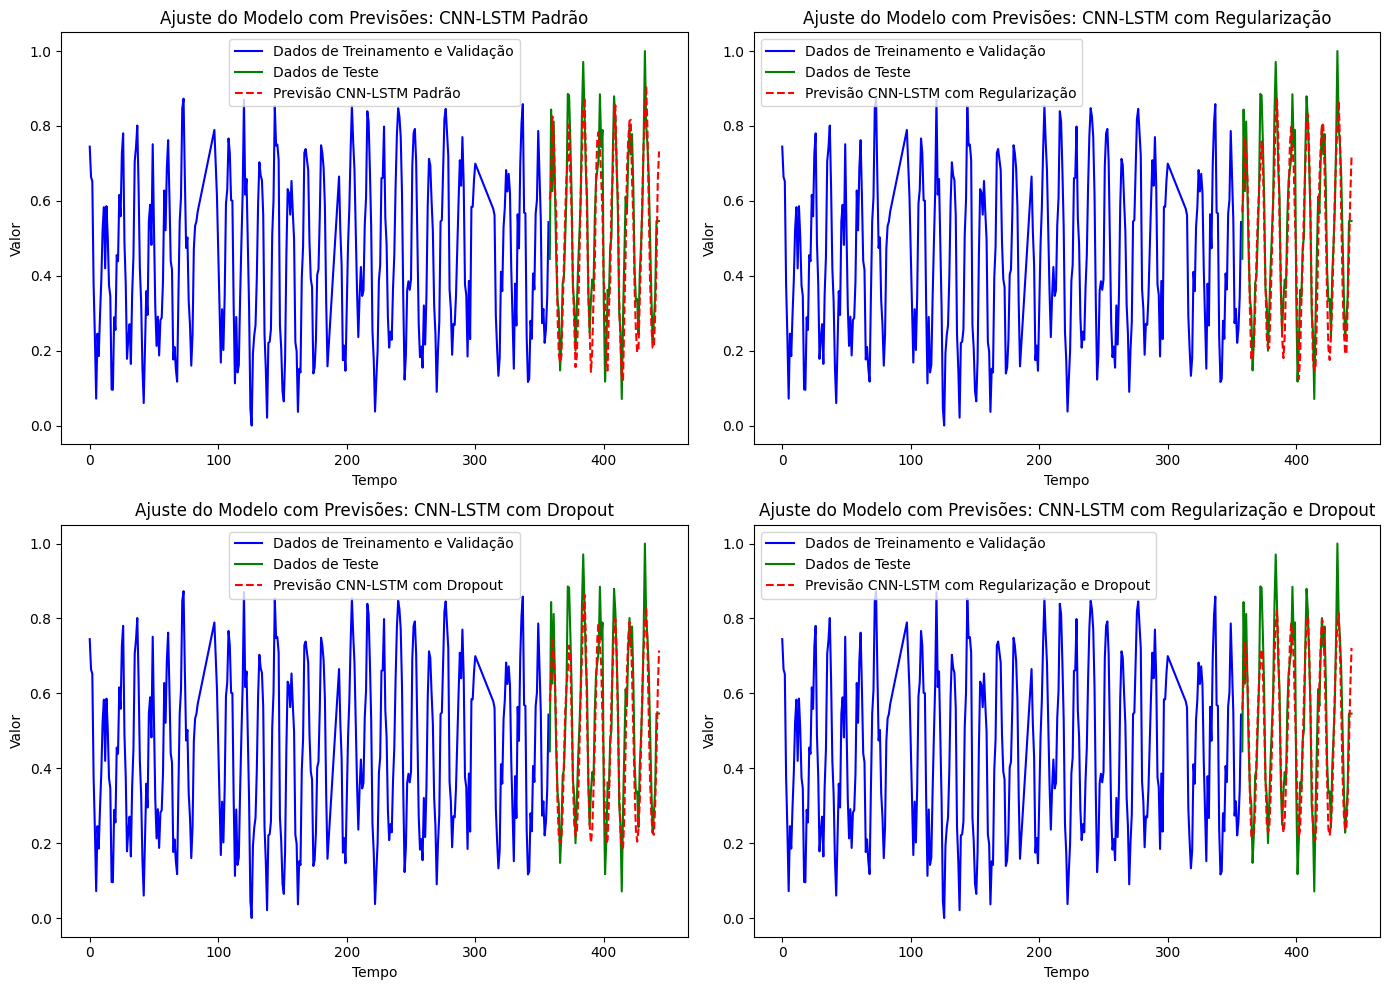

In [77]:
# Combine os dados de treino e validação em uma série para comparação visual com o conjunto de teste e previsões.
train_valid_data = np.concatenate([Y_train, Y_valid])  # Combina Y_train e Y_valid em uma série contínua

# Lista com previsões e nomes dos modelos para plotar
y_pred_models = [y_pred_cnn_lstm, y_pred_cnn_lstm_reg, y_pred_cnn_lstm_drop, y_pred_cnn_lstm_reg_drop]
model_names = ["CNN-LSTM Padrão", "CNN-LSTM com Regularização", "CNN-LSTM com Dropout", "CNN-LSTM com Regularização e Dropout"]

# Chamando a função para exibir os gráficos lado a lado
plot_multiple_predictions(train_valid_data, Y_test, y_pred_models, model_names)